In [6]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../utilities')
from basic_utilities import *
from model_utilities import *
from pandas.plotting import scatter_matrix
from ml_utilities import sk_feature_selection
import scipy.stats as stats
import pdb
import os
import warnings
warnings.filterwarnings("ignore")
import gower
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

In [7]:
raw_data = pd.read_csv('../../../data/Base.csv')

In [8]:
raw_data.columns

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'],
      dtype='object')

### gower distance

In [31]:
drivers = ['credit_risk_score','name_email_similarity', 'email_is_free', 'phone_mobile_valid', 'foreign_request','keep_alive_session','has_other_cards']

In [33]:
sample = raw_data.sample(frac=0.1, random_state = 1234)

In [8]:
gower_mat = gower.gower_matrix(sample[drivers], cat_features=[False, False, True, True, True, True, True])



In [15]:
kmeans = MiniBatchKMeans(n_clusters=3, random_state=0).fit(gower_mat)

In [26]:
silhouette_score(
            gower_mat,
            kmeans.labels_,
            metric="precomputed",
            random_state = 123
        )

0.35415035

In [27]:
sample['kmean_label'] = kmeans.labels_

In [28]:
sample.to_csv('sample_after_kmeans.csv', index=False)

### Euclidean distance

In [37]:
drivers = ['credit_risk_score','name_email_similarity','proposed_credit_limit','customer_age','zip_count_4w','current_address_months_count']

In [39]:
raw_data1 = raw_data[drivers].sample(frac = 0.1, random_state = 31234)

<Axes: xlabel='proposed_credit_limit', ylabel='current_address_months_count'>

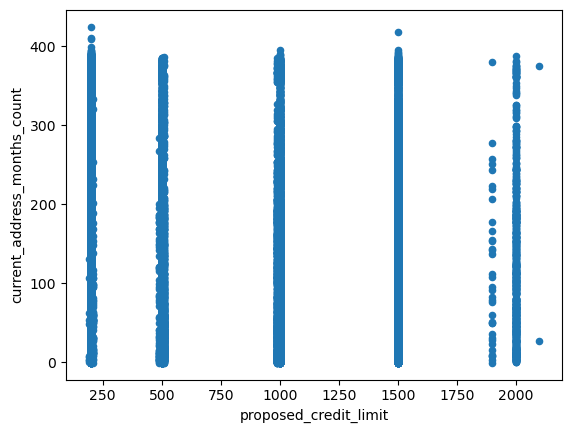

In [41]:
raw_data1.plot.scatter(x='proposed_credit_limit', y='current_address_months_count')

<Axes: title={'center': 'days_since_request'}, xlabel='fraud_bool'>

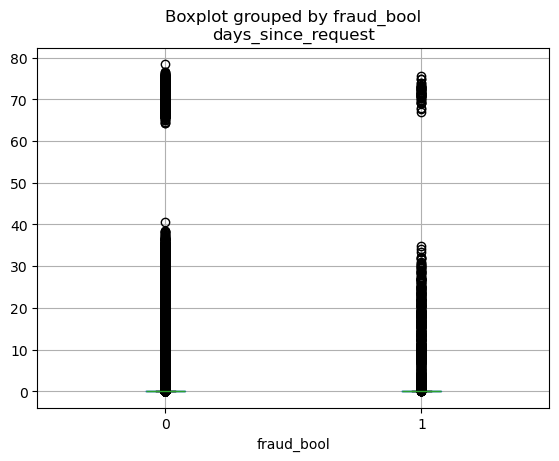

In [43]:
raw_data.boxplot(column='days_since_request', by='fraud_bool')

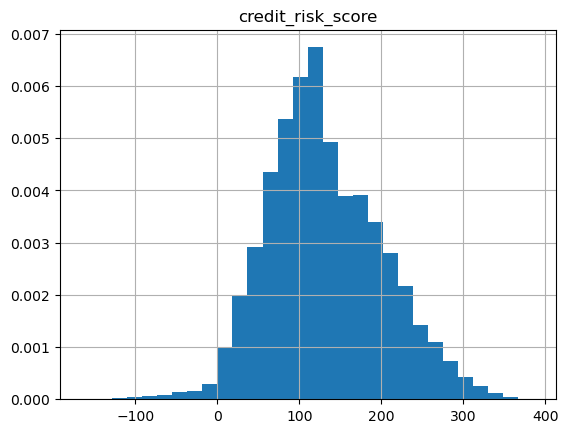

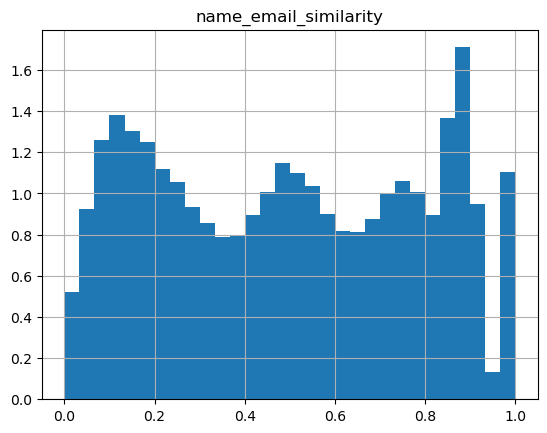

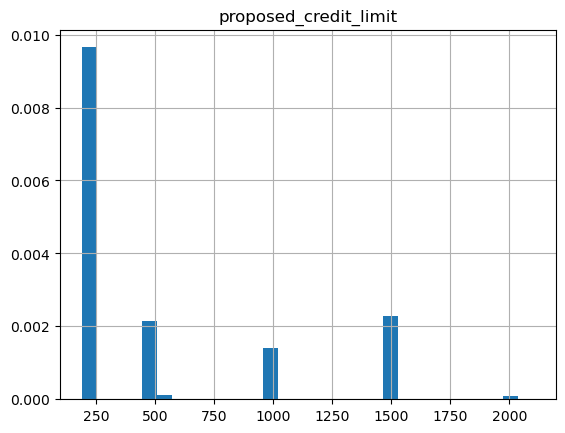

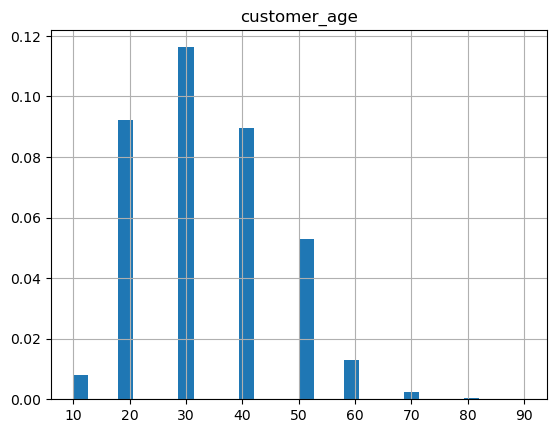

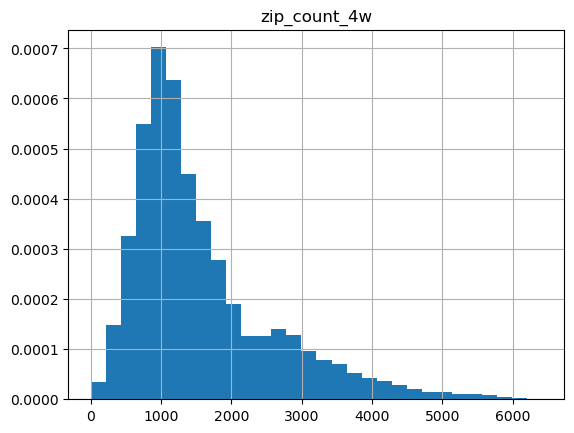

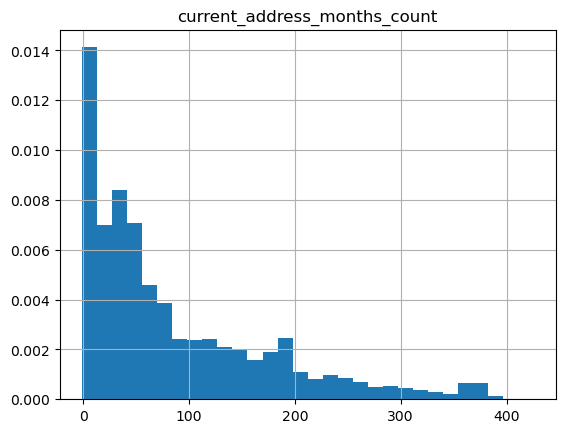

In [45]:
for var in drivers:
    fig = plt.figure()
    plt.title(var)
    raw_data1[var].hist(density=True, bins=30)

In [47]:
scaler = StandardScaler()
raw_data1[drivers] = scaler.fit_transform(raw_data1[drivers])

In [247]:
inertia = []
models = []
max_cluster = 30
for i in range(2,max_cluster):
    kmeans = KMeans(init="k-means++",n_clusters=i, random_state=0).fit(raw_data1)
    inertia.append(kmeans.inertia_)
    models.append(kmeans)

Text(0, 0.5, 'inertia')

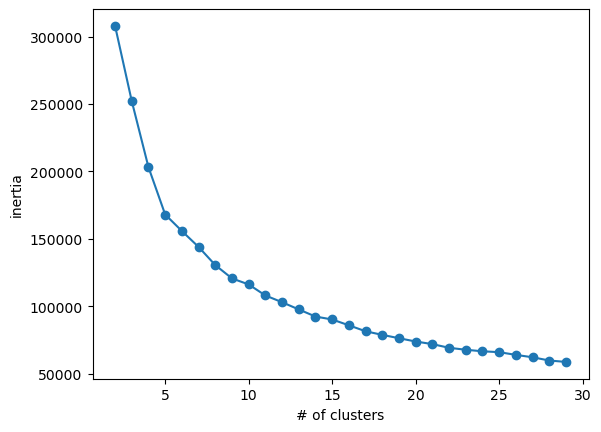

In [248]:
plt.plot(range(2,max_cluster),inertia, marker='o')
plt.xlabel('# of clusters')
plt.ylabel('inertia')

In [251]:
silhouette_score(raw_data1,models[5].labels_,random_state = 123)

0.29356944721647493

In [183]:
db_clustering = DBSCAN(eps=0.8).fit(raw_data1)

In [184]:
max(db_clustering.labels_)

8

In [49]:
gm = GaussianMixture(n_components=3, random_state=0, init_params='k-means++').fit(raw_data1[['credit_risk_score','name_email_similarity']])

In [51]:
gm.means_

array([[-0.39973597,  0.64712165],
       [ 1.13170796,  0.4520727 ],
       [-0.09601496, -1.08188219]])

In [55]:
gm.converged_

True

In [57]:
gm.covariances_

array([[[0.5951796 , 0.05449947],
        [0.05449947, 0.43928947]],

       [[0.64038001, 0.04543309],
        [0.04543309, 0.58607413]],

       [[0.80873379, 0.01251822],
        [0.01251822, 0.12664178]]])

In [82]:
raw_data1['cluster'] = gm.predict(raw_data1[['credit_risk_score','name_email_similarity']])

In [89]:
px_scatter_plot(raw_data1, 'credit_risk_score', 'name_email_similarity', color_var='cluster')

In [9]:
raw_data['keep_alive_session'].value_counts()

keep_alive_session
1    576947
0    423053
Name: count, dtype: int64

In [27]:
raw_data_session_alive = raw_data.loc[raw_data['keep_alive_session']==1]

In [29]:
raw_data_session_dead = raw_data.loc[raw_data['keep_alive_session']==0]

In [31]:
drivers = ['credit_risk_score','name_email_similarity']

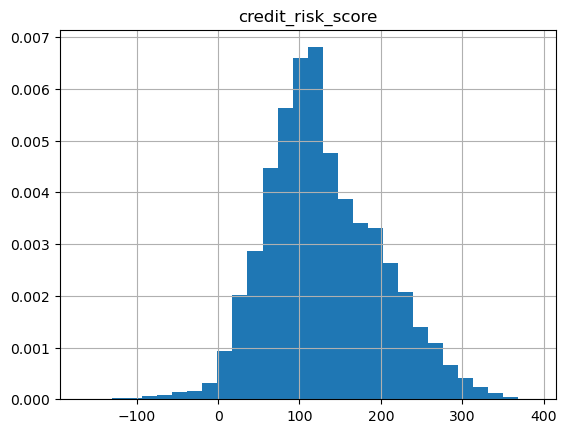

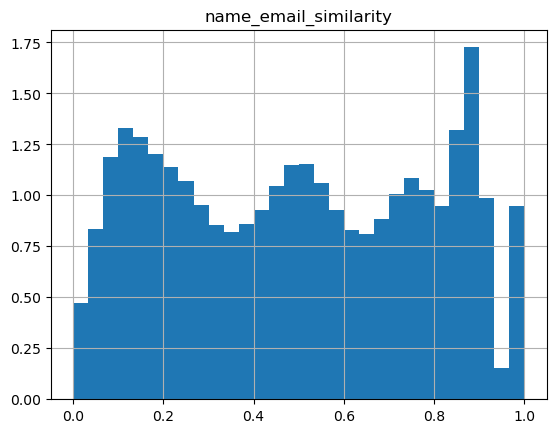

In [33]:
for var in drivers:
    fig = plt.figure()
    plt.title(var)
    raw_data_session_alive [var].hist(density=True, bins=30)

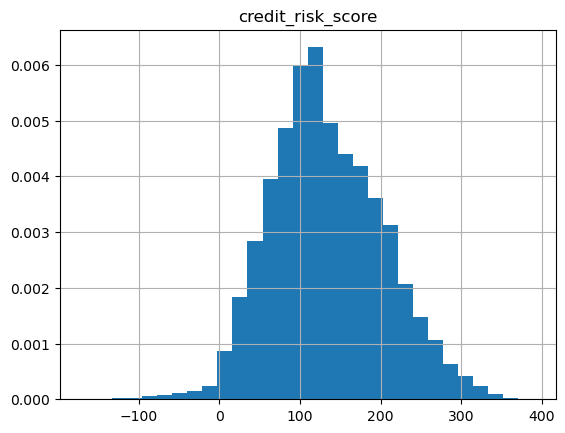

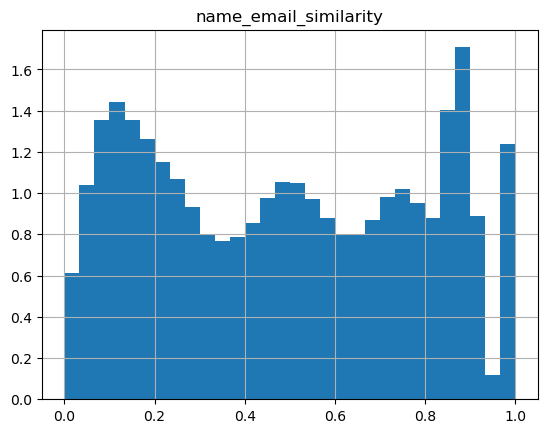

In [35]:
for var in drivers:
    fig = plt.figure()
    plt.title(var)
    raw_data_session_dead[var].hist(density=True, bins=30)

In [53]:
gm1 = GaussianMixture(n_components=3, random_state=0, init_params='k-means++').fit(raw_data_session_alive[['credit_risk_score','name_email_similarity']])

In [47]:
gm2 = GaussianMixture(n_components=3, random_state=0, init_params='k-means++').fit(raw_data_session_dead[['credit_risk_score','name_email_similarity']])

In [55]:
gm1.means_

array([[178.0309671 ,   0.5127076 ],
       [ 91.9044749 ,   0.48443013],
       [259.39679296,   0.54695381]])

In [65]:
gm1.covariances_

array([[[ 1.76382824e+03,  6.24432370e-01],
        [ 6.24432370e-01,  8.09026561e-02]],

       [[ 2.09516200e+03, -2.00485695e-01],
        [-2.00485695e-01,  8.13488013e-02]],

       [[ 1.47562630e+03,  6.19912359e-01],
        [ 6.19912359e-01,  7.82484284e-02]]])

In [57]:
gm2.means_

array([[126.43546367,   0.49368382],
       [ 72.63192553,   0.46863035],
       [205.22937974,   0.50564519]])

In [67]:
gm2.covariances_

array([[[ 1.15426517e+03,  5.60608815e-02],
        [ 5.60608815e-02,  8.74963068e-02]],

       [[ 1.96800086e+03, -7.72521045e-01],
        [-7.72521045e-01,  8.55745023e-02]],

       [[ 2.41410384e+03,  8.15866508e-01],
        [ 8.15866508e-01,  8.61304976e-02]]])